In [1]:
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
loan = pd.read_csv('Loan_status_2007-2020Q3.csv').iloc[:, 1:]
# loan = pd.read_csv('loan_10%.csv').iloc[:, 1:]
loan

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925488,102556443,24000.0,24000.0,24000.0,60 months,23.99%,690.30,E,E2,Senior Escrow Officer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2925489,102653304,10000.0,10000.0,10000.0,36 months,7.99%,313.32,A,A5,Rn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2925490,102628603,10050.0,10050.0,10050.0,36 months,16.99%,358.26,D,D1,Sales Associate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2925491,102196576,6000.0,6000.0,6000.0,36 months,11.44%,197.69,B,B4,Contact input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


some domain knowledge

account types:
- revolving account (rv/rev) and open revolving account
    https://finance.yahoo.com/news/credit-101-revolving-account-160156744.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuYmluZy5jb20v&guce_referrer_sig=AQAAAC5tynIU9PSiuHiOsa8TUXN46hin0knyqXtRWEYZxFfiZt0min4vpyutMQhXwjLeGrNSBBmR5HNdJmnlQ6PzxMURqb_J4KINLWrbtxUU2yVXqQUi8mmTzfh1IQkXxeEm9RkSduAW2Wz2-nzYTqNMo2cRW0w8egEIcv1Hf171RAr7
- installment account (il)
- bankcard account (bc)
- mortgage account

ratio types:
- util rate
- dti
- high credit / credit limit

rename for standardizing the column names

In [4]:
find = [
    'mths_since_rcnt_il', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', # rcnt and mo_sin_rcnt
    'mths_since_recent_bc_dlq', 'pct_tl_nvr_dlq', # dlq
    'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', # mo_sin_old
]
replace = [
    'mths_since_recent_il', 'mths_since_recent_rev_tl_op', 'mths_since_recent_tl', # recent and mths_since
    'mths_since_recent_bc_delinq', 'percent_tl_nvr_deliq', # delinq
    'mths_since_old_il_acct', 'mths_since_old_rev_tl_op' # mths_since_old
]

loan.rename(columns={
    find[i]: replace[i] for i in range(len(find))
}, inplace=True)

del find, replace

change these back to datetime

In [5]:
datetime_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d',
                    'last_credit_pull_d', 'sec_app_earliest_cr_line', 'hardship_start_date',
                    'hardship_end_date', 'payment_plan_start_date']

for col in datetime_columns:
    loan[col] = pd.to_datetime(loan[col], format='%b-%Y')

remove loan data issued before 1-1-2013

In [6]:
loan['issue_d_year'] = loan['issue_d'].dt.year
loan = loan[loan['issue_d_year'] > 2012]

change int_rate, revol_util from dd% to dd

In [7]:
loan['int_rate'] = loan['int_rate'].apply(
    lambda x: float(x.strip().split('%')[0]) if pd.notnull(x) else np.nan
)

In [8]:
loan['revol_util'] = loan['revol_util'].apply(
    lambda x: float(x.strip().split('%')[0]) if pd.notnull(x) else np.nan
)

create a column for deciding if it is matured loan

In [9]:
loan['is_matured_loan'] = loan['next_pymnt_d'].isna()

In [10]:
loan = loan[loan['is_matured_loan']]

create functions to handle na

In [11]:
# handling columns with missing value (not used)
def check_dtype(df, col):
    if df[col].dtype == 'object':
        return 'object'
    elif np.modf(df[col])[0].nunique() == 1:
        return 'int'
    else:
        return 'float'

In [12]:
# turn some into happens or not
# e.g. for months since last delinquent, people have NA in their record as they never delinq.
def convert_to_bin(df, col):
    df[col + '_binary'] = (~df[col].isna()) * 1

# fill na with most freq. values or empty / 0
def fill_na(df, col, method):
    if method == 'mode':
        to_fill = df[col].value_counts().index[0]
    elif method == 'mean':
        to_fill = df[col].mean()
    elif method == 'zero':
        to_fill = 0
    elif method == 'string':
        to_fill = ''
    else:
        raise ValueError("method must be 'mode', 'mean', 'zero' or 'string'.")
    df[col].fillna(to_fill, inplace=True)

In [13]:
# handle columns starting with 'mths_since'
# motivation: e.g. NAN in number of months since the last delinquent = the applicant has a clean record
# use binary variable to represent instead of number of months
mths_since_to_drop = []

for col in loan.columns:
    if 'mths_since_' in col and col not in ['mths_since_recent_rev_tl_op', 
                                            'mths_since_recent_tl']:
        convert_to_bin(loan, col)
        mths_since_to_drop.append(col)

In [14]:
# these are only able after 2015

# ratio or balance
for col in ['il_util', 'all_util', 'total_bal_il', 'max_bal_bc']:
    fill_na(loan, col, 'mean')
    
# times
for col in ['open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
            'open_rv_12m', 'open_rv_24m', 'inq_fi', 'total_cu_tl', 'inq_last_12m']:
    fill_na(loan, col, 'mode')

In [15]:
# fill by 0 in general
for col in ['deferral_term']:
    fill_na(loan, col, 'zero')

In [16]:
# fill by max entry in general
for col in ['emp_length', 'num_tl_120dpd_2m', 'hardship_flag',
            'num_rev_accts', 'inq_last_6mths', 'zip_code']:
    fill_na(loan, col, 'mode')

In [17]:
# fill by mean in general
for col in ['percent_bc_gt_75', 'bc_util', 'revol_util', 'dti',
            'percent_tl_nvr_deliq', 'avg_cur_bal', 'bc_open_to_buy']:
    fill_na(loan, col, 'mean')

In [18]:
# fill by empty string in general
for col in ['emp_title', 'title', 'purpose']:
    fill_na(loan, col, 'string')

create columns

In [19]:
# loan to income ratio
loan['loan_to_income'] = loan.loan_amnt / (loan.annual_inc + 1)

# delinq to income ratio
loan['deliq_to_income'] = loan.delinq_amnt / (loan.annual_inc + 1)

# revol_bal to income ratio
loan['revol_to_income'] = loan.revol_bal / (loan.annual_inc + 1)

# tot_cur_bal to income ratio
loan['tot_cur_bal_to_income'] = loan.tot_cur_bal / (loan.annual_inc + 1)

# max_bal_bc to income ratio
loan['max_bal_bc_to_income'] = loan.max_bal_bc / (loan.annual_inc + 1)

# avg_cur_bal to income ratio
loan['avg_cur_bal_to_income'] = loan.avg_cur_bal / (loan.annual_inc + 1)

# total_bal_ex_mort to income ratio
loan['total_bal_ex_mort_to_income'] = loan.total_bal_ex_mort / (loan.annual_inc + 1)

# ratio of the number of open credit lines to the number of total credit lines in the borrower's credit file.
loan['open_cl_ratio'] = loan['open_acc'] / loan['total_acc']

# fico change
loan['FICO_change'] = loan.apply(
    lambda r: r['fico_range_high'] / r['last_fico_range_high'] if r['last_fico_range_high'] > 0 else 1, axis=1
)

calculate installment

In [20]:
def month_diff(a, b):
    return 12 * (a.dt.year - b.dt.year) + (a.dt.month - b.dt.month)

num_mths_to_pay = month_diff(
    pd.to_datetime(loan.last_pymnt_d), 
    pd.to_datetime(loan.issue_d)
)

missing_num_mths_to_pay = loan[loan.last_pymnt_d.isna()].apply(
    lambda x: x['total_pymnt']//x['installment'] if x['total_pymnt'] > 0 else 0, axis=1
)

num_mths_to_pay[num_mths_to_pay.isna()] = missing_num_mths_to_pay

In [21]:
p = loan['funded_amnt']
r = loan['int_rate'] / 100
n = loan['term'].apply(lambda x: int(x.strip()[:2]))

loan['calculated_installment'] = p * (r/12) * (1+r/12)**n / ((1+r/12)**n - 1)

In [22]:
loan[['installment', 'calculated_installment']]

,installment,calculated_installment
42536,392.81,392.807780
42537,157.13,157.123112
42538,885.46,885.454205
42539,373.94,373.936320
42540,470.71,470.704473
...,...,...
2925488,690.30,690.291882
2925489,313.32,313.317525
2925490,358.26,358.259896
2925491,197.69,197.684869


calculate ROI

The cash flow of a loan consists of five possible parts: Principal, interest, late fees, sales proceeds, and recovery amount.8 From the lender’s perspective, the typical set of cash flows for a loan may look like the following: {−P0, P1, . . . , PT }, consisting of an initial cash outflow P0 and monthly cash inflows {Pt, t ∈ {1, . . . , T}} until the loan is fully paid or charged off. We can approximate the monthly payments of a loan by the average monthly payment, i.e., the total payments received divided by the number of months between origination and the last payment. The cash flows for a portfolio of loans can be generated by summing up the cash flows of constituent loans

The monthly payments information is not available in our dataset. We approximate the monthly payment based on loan origination date, last payment date, total payments, and collection recovery fee.

- P0 = funded amount (the inital cashflow)
- P1...PT are calculated from issue_d, last_pymnt_d, total_pymnt, collection_recovery_fee (charge off), recoveries

In [23]:
# assume
depreciation_rate = 0.02

In [24]:
tmp = pd.DataFrame({
    'funded_amnt': loan['funded_amnt'] * -1,
    'avg_pymnt': loan['total_pymnt'] / num_mths_to_pay,
    'num_mths_to_pay': num_mths_to_pay.astype(int)
})

In [25]:
tmp.loc[tmp['num_mths_to_pay']==0, 'avg_pymnt'] = loan.loc[tmp['num_mths_to_pay']==0, 'last_pymnt_amnt']

In [26]:
CDP = tmp['num_mths_to_pay'].apply(
    lambda x: np.sum([(1+depreciation_rate/12)**(-t) for t in range(1, int(x)+1)])
) * tmp['avg_pymnt']

In [27]:
# for those immediately paid right after issued
CDP[(tmp['avg_pymnt']>0)&(tmp['num_mths_to_pay']==0)] = tmp['avg_pymnt'][(tmp['avg_pymnt']>0)&(tmp['num_mths_to_pay']==0)]

In [28]:
# approximately 6 months after last payment
net_recoveries = loan['recoveries'] - loan['collection_recovery_fee']
depreciated_net_recoveries = net_recoveries[net_recoveries>0] * \
                                tmp['num_mths_to_pay'][net_recoveries>0]\
                                    .apply(lambda x: 1/(1+depreciation_rate/12)**(x+6))

CDP[net_recoveries>0] += depreciated_net_recoveries

In [29]:
ROI = ((CDP + tmp['funded_amnt']) / - tmp['funded_amnt'])

In [30]:
loan['ROI'] = ROI

<Axes: ylabel='Frequency'>

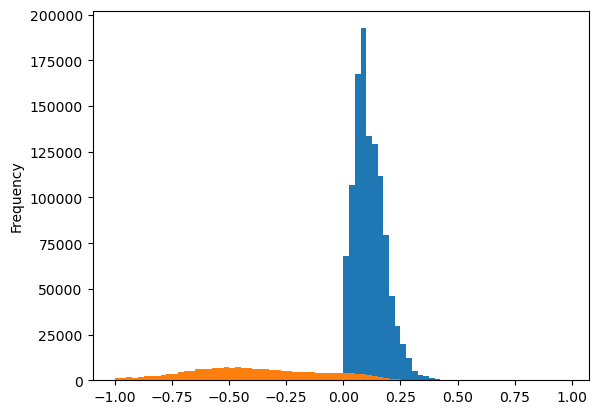

In [31]:
loan[
    (loan.loan_status.str.contains('Fully'))&(loan.term.str.contains('36'))
].ROI.plot.hist(bins=[-1+i*0.025 for i in range(80)])
                      
loan[
    (loan.loan_status.str.contains('Charged'))&(loan.term.str.contains('36'))
].ROI.plot.hist(bins=[-1+i*0.025 for i in range(80)])

calculate IRR

In [32]:
# For fully paid but they paid right after the loans were issued
tmp.loc[(loan.issue_d == loan.last_pymnt_d)&(loan.loan_status.str.contains('Fully')), 'num_mths_to_pay'] = 1

In [33]:
cf = tmp.apply(lambda r: [r['funded_amnt']] + [r['avg_pymnt']]*int(r['num_mths_to_pay']), axis=1)

In [34]:
def irr(cash_flow):
    """
    Solving this to get IRR:
    p0 + p1 * (1 + IRR)^(-1) + p2 * (1 + IRR)^(-2) + ... + pn * (1 + IRR)^(-n) = 0 _ (*)

    Let g = 1 + IRR and multiply (*) by g^n and you will get:
    p0 * g^n + p1 * g^(n-1) + p2 * g^(n-2) + ... + pn = 0

    Then solve the polynomial and get the positive roots
    IRR = g - 1

    :param: cash_flow: a stream of cash flow to pay and receive with a NPV = 0
    """
    cash_flow = np.array(cash_flow)
    same_sign = np.all(cash_flow > 0) if cash_flow[0] > 0 else np.all(cash_flow < 0)
    if same_sign:
        if len(cash_flow) == 1 and cash_flow[0] < 0:
            return -1
        
        raise ValueError("cash_flow must contain positive and negative values")

    g = np.roots(cash_flow)
    IRR = np.real(g[np.isreal(g)]) - 1

    # realistic IRR
    IRR = IRR[(IRR <= 1)&(IRR >= -1)]

    # if no real solution
    if len(IRR) == 0:
        return np.nan

    # if only one real solution
    if len(IRR) == 1:
        return IRR[0]

    # check sign of all IRR solutions
    same_sign = np.all(IRR > 0) if IRR[0] > 0 else np.all(IRR < 0)
    
    # if not the same, first filter potential IRR by comparing the total positive and negative cash flows
    if not same_sign:
        pos = sum(cash_flow[cash_flow>0])
        neg = sum(cash_flow[cash_flow<0])
        if pos >= neg:
            IRR = IRR[IRR >= 0]
        else:
            IRR = IRR[IRR < 0]
    
    # pick the smallest one in magnitude and return
    abs_IRR = np.abs(IRR)
    return IRR[np.argmin(abs_IRR)]

In [35]:
irr_res = cf.apply(irr)

In [36]:
loan['IRR'] = irr_res

In [37]:
print(loan.loc[(loan.term.str.contains('36')), 'IRR'].mean(),
      loan.loc[(loan.term.str.contains('36'))&(loan.loan_status.str.contains('Fully')), 'IRR'].mean(),
      loan.loc[(loan.term.str.contains('36'))&(loan.loan_status.str.contains('Charged')), 'IRR'].mean())

-0.012521647695488063 0.012313792411589988 -0.14495831525395558


In [38]:
print(loan['IRR'].mean(),
      loan.loc[(loan.loan_status.str.contains('Fully')), 'IRR'].mean(),
      loan.loc[(loan.loan_status.str.contains('Charged')), 'IRR'].mean())

-0.017049150992344653 0.013682444402946659 -0.14227073445799196


drop irrelevant columns

In [40]:
to_drop = [
    col for col in loan.columns if 
        ('hardship' in col and 'hardship_flag' != col) or 
        ('mths_since_' in col and '_binary' not in col) or 
        ('sec_app' in col) or 
        ('joint' in col)
        
] + [
    'orig_projected_additional_accrued_interest', 
    'payment_plan_start_date', 'pymnt_plan',
    'issue_d_year', 'policy_code',
    'next_pymnt_d', 'earliest_cr_line',
    'url', 'last_credit_pull_d', 'last_pymnt_d'
    
] + mths_since_to_drop

loan.drop(to_drop, axis=1, inplace=True)

In [41]:
class MissingValueError(Exception):
    pass

if loan.isna().sum().sum() > 0:
    raise MissingValueError('Found missing value')

In [42]:
loan.shape

(1767178, 118)

binning

In [55]:
def binning_int_rate(int_rate):
    if int_rate < 10:
        return 'less than 10%'
    for i in range(2, 6):
        if i*5 <= int_rate and (i+1)*5 > int_rate:
            return f'within {i*5}% and {i*5+5}%'
    return 'greater than or equal to 30%'

loan['int_rate_bin'] = loan['int_rate'].apply(binning_int_rate)

In [56]:
def binning_income(income):
    if income < 20000:
        return 'less than 20k'
    for i in range(2, 16):
        if i*10000 <= income and (i+1)*10000 > income:
            return f'within {i*10}k and {(i+1)*10}k'
    return f'greater than or equal to {(i+1)*10}k'

loan['annual_inc_bin'] = loan['annual_inc'].apply(binning_income)

load to database

In [57]:
import json
import mysql.connector
from sqlalchemy import create_engine

In [58]:
with open('db_config.json', 'r') as json_file:
    db_config = json.load(json_file)

try:
    # Attempt to connect to the MySQL server
    connection = mysql.connector.connect(**db_config)

    # Check if the connection is successful
    if connection.is_connected():
        print("Connected to MySQL Server")
        
#     sql = "DROP TABLE matured_loan"
#     cursor = connection.cursor()
#     cursor.execute(sql)

    # Close the connection
    connection.close()

except mysql.connector.Error as err:
    print(f"Error: {err}")
    print("Failed to connect to MySQL Server")

Connected to MySQL Server


In [60]:
engine = create_engine(
    f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"
)

In [61]:
with engine.begin() as connection:
    try:
        table_name = 'matured_loan'

        # Start an explicit control over transaction
        tran = connection.begin()
        
        # Insert the DataFrame data into the MySQL table using explicit transaction in append mode
        loan.to_sql(name=table_name, 
                    con=connection, 
                    if_exists='replace', 
                    chunksize=1000,
                    index=False)
        
        # Commit the transaction explicitly if above insert statements work fine
        tran.commit()
        print("Transaction committed successfully.")
    except Exception as e:
        # Roll back the transaction if any error occurs
        tran.rollback()
        print("Transaction rolled back due to an error:", e)

Transaction committed successfully.


In [62]:
connection.close()